<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/credit_card_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit card fraud detection with SVM

Classify credit card transactions with highly imbalanced dataset (only minor portion of transactions are frauds).

The data is anonymized and run through PCA. All V-prefix features are principal components obtained with PCA.

In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d 'mlg-ulb/creditcardfraud'

Saving kaggle.json to kaggle.json
 64% 42.0M/66.0M [00:00<00:00, 89.8MB/s]
100% 66.0M/66.0M [00:00<00:00, 122MB/s] 


In [2]:
! unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


In [3]:
import pandas as pd

file_path = '/content/creditcard.csv'
data = pd.read_csv(file_path)

### Data exploration

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
def calculate_positive_portion(data):
  fraud_pct =  data.value_counts()[1] / data.shape[0]
  print('Fraud portion', fraud_pct, '%')

calculate_positive_portion(data['Class'])

Fraud portion 0.001727485630620034 %


In [8]:
X = data.drop('Class', axis=1)
y = data['Class']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


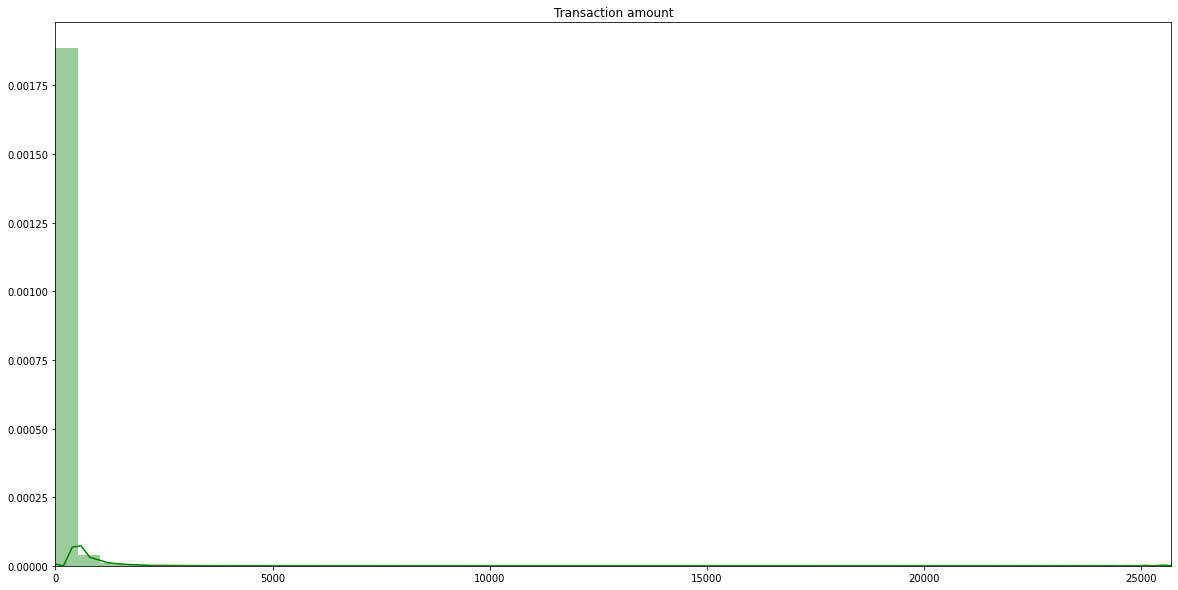

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

amount = data['Amount']

plt.figure(figsize=(20,10))
plt.title('Transaction amount')
plt.xlim((0, amount.max()))

sns.distplot(amount.values, color='g')

The data description told us, that PCA was used before. In order to use PCA, the dataset must be scaled, so we can skip standardization part in data preparation phase. Only time and amount columns are not scaled

### Data preprocessing

With SVM models, it's important to scale the features, otherwise SVM will neglect the smaller feature scales.

### Scaling

Scale amount and time columns with RobustScaler. RobustScaler focuses on the part where the most data is. Because RobustScaler uses interquartile range instead of min and max values, it's robust to outliers than typical normalization. StandardScaler is another option, but it does not work well if the data does not follow Gaussian distribution already.

In [10]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

data['scaled_time'] = rs.fit_transform(data['Time'].values.reshape(-1, 1))
data['scaled_amount'] = rs.fit_transform(data['Amount'].values.reshape(-1, 1))

data.drop(['Time', 'Amount'], axis=1, inplace=True)


In [11]:
scaled_time = data['scaled_time']
scaled_amount = data['scaled_amount']

data.drop(['scaled_time', 'scaled_amount'], axis=1, inplace=True)
data.insert(0, 'scaled_time', scaled_time)
data.insert(1, 'scaled_amount', scaled_amount)

In [12]:
data.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


#### Rebalancing the data

We need to deal with heavily imbalanced dataset (almost non-existing portion of frauds) so that our model can detect the patterns between fraudulent and non-fraudulent.

Keypoints:
- Train the model with balanced data so the model will detect the patterns
- Test the model with original data to get unbiased results about the performance

#### Undersampling
Remove some data to get balanced (50/50) set of fraudulent and non-fraudulent samples.

We have 492 fraudulent samples which means we reduce non-fraudulent samples down to 492. Notice, that this will cause a massive information loss on the part of non-fraudulent patterns.


In [13]:
# Shuffle data by resampling
data = data.sample(frac=1)
fraudulent = data[data['Class'] == 1]
non_fraudulent = data[data['Class'] == 0][:492]

# Shuffle balanced data again so model does not pick any correlation from the order
balanced_df = pd.concat([fraudulent, non_fraudulent]).sample(frac=1, random_state=42)

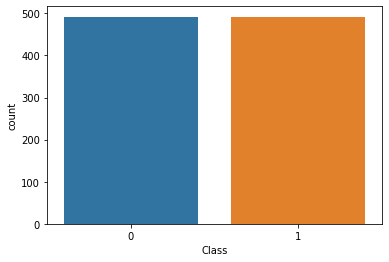

In [14]:
sns.countplot('Class', data=balanced_df)

#### Correlations

Correlation analysis should be done on the subsample to detect highly correlated features.

TODO


#### Outlier removal
TODO

### Model training

We'll use SVC as our main classifier with undersampled data.
The data should be undersampled DURING THE CROSSVALIDATION, otherwise the model most probably overfits and gives us biased results.

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import LinearSVC

X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

clf = LinearSVC()

# Accuracy, no oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)
scores = cross_val_score(clf, X, y, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [16]:
print("Training score ", round(scores.mean(), 2) * 100, "% accuracy score")

Training score  94.0 % accuracy score


Accuracy for classification is 94%. This means nothing since the data is heavily balanced. Other metrics like precision/recall and ROC should be used as evaluation metric for classification problem.


In [17]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(clf, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    fig = plt.figure(figsize=(15,10))
    if ylim is not None:
        plt.ylim(*ylim)
    
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax = plt.gca()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax.set_xlabel('Training size (m)')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

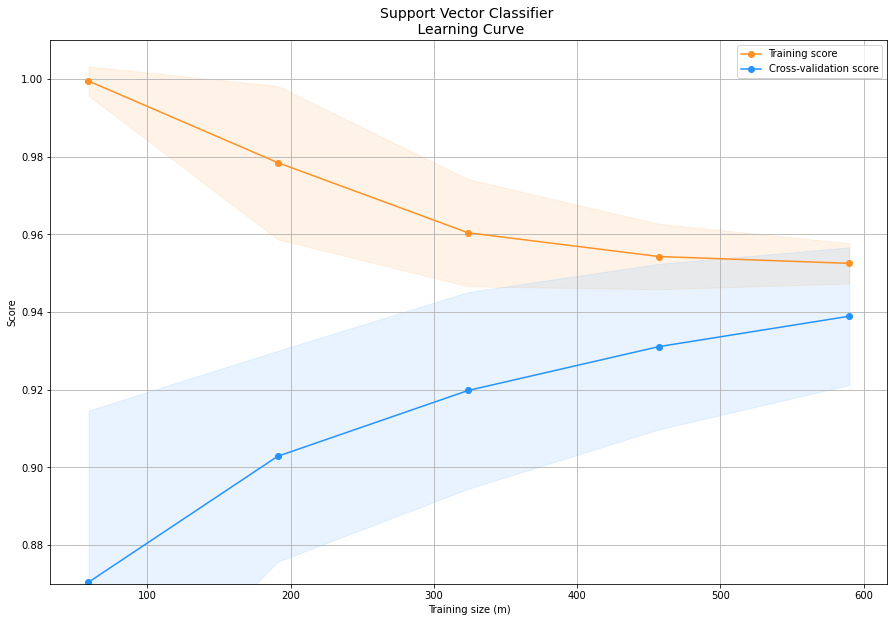

In [18]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [26]:
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(clf, X_train, y_train, cv=5, method='decision_function')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [29]:
from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, pred)

In [44]:
from sklearn.metrics import roc_auc_score
print('Area under curve: ', roc_auc_score(y_train, pred))

Area under curve:  0.9660740403201505


In [52]:
def plot_roc_curve(false_positive_rate, true_positive_rate, pred, y):
  plt.figure(figsize=(16,8))
  plt.title('ROC Curve', fontsize=15)
  plt.plot(false_positive_rate, true_positive_rate, label='Support Vector Classifier score: {:.4f}'.format(roc_auc_score(y, pred)))
  plt.plot([0, 1], [0, 1], 'r-')
  plt.axis([-0.01, 1, 0, 1])
  plt.xlabel('False Positive Rate', fontsize=15)
  plt.ylabel('True Positive Rate', fontsize=15)
  plt.annotate('Minimum ROC score (50%)', xy=(0.5, 0.5), xytext=(0.6, 0.4), arrowprops=dict(facecolor='#FF0000', shrink=0.05))
  plt.legend()
  plt.show()


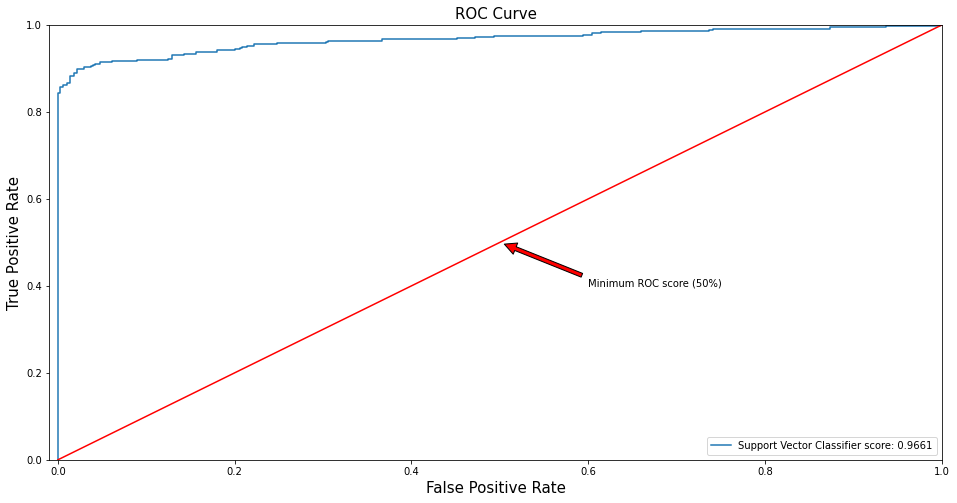

In [53]:
plot_roc_curve(false_positive_rate, true_positive_rate, pred, y_train)

In [19]:
# def display_scores(scores):
#     print("Scores:", scores)
#     print("Mean:", scores.mean())
#     print("Standard deviation:", scores.std())

# display_scores(scores)

In [20]:
# from sklearn.pipeline import make_pipeline
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler

# pipeline = make_pipeline(StandardScaler(), LinearSVC(C=10))

In [21]:
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=10)

In [22]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(pipeline, X, y, cv=skf, scoring='recall')

### Model evaluation


The focus is to find maximize recall particularly which means that we want our model to detect as many positive cases as possible.

In [23]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall_curve(y_true, y_pred):
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.1])
  plt.xlim([0.0, 1.0])

def report_results(clf, X, y):
  print('Number of normal transactions:', len(y[y == 0]))
  print('Number of frauds:', len(y[y == 1]))
  
  clf_report = classification_report(y_true, y_pred)
  print(clf_report)

  plot_precision_recall_curve(y_true, y_pred)
  plot_confusion_matrix(clf, X, y)
  plot_roc_curve(clf, X, y)